100%|███████████████████████████████████████████████████████████████████████████ 1000/1000 [ETA: 00:00, Elapsed: 09:28]


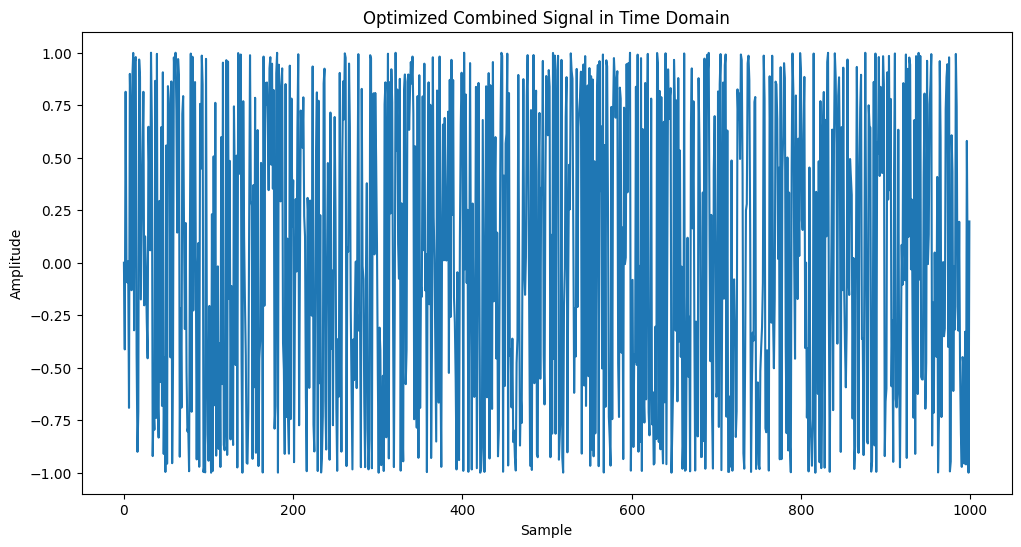

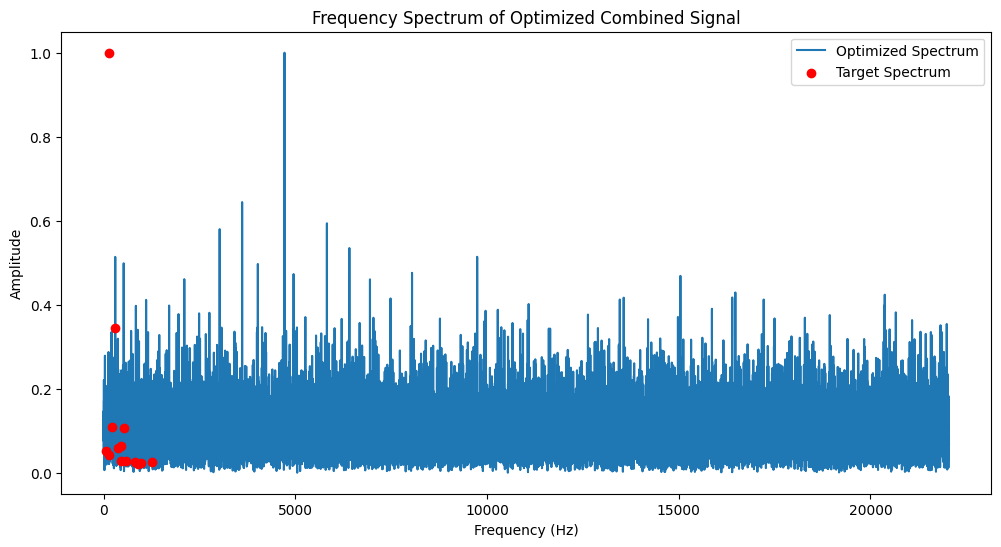

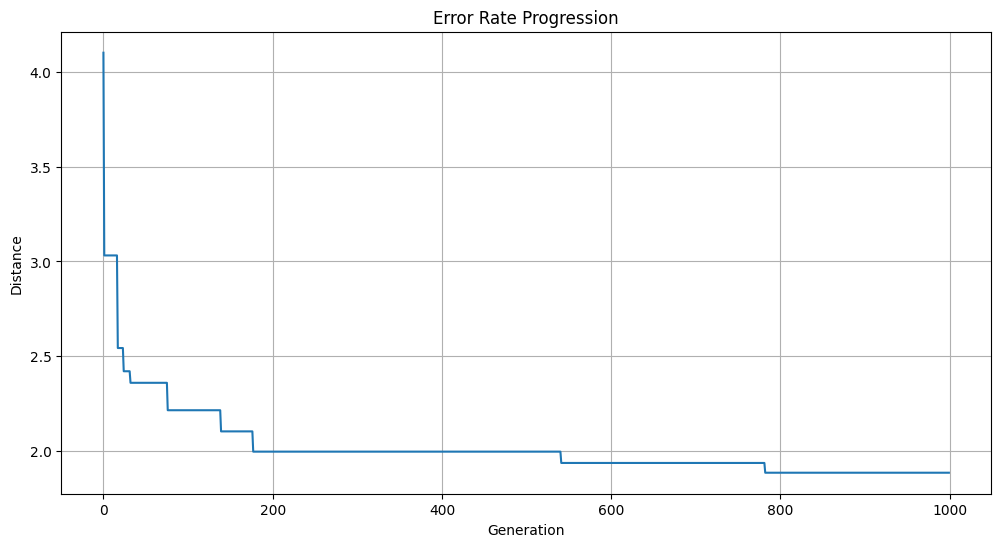

Modulator 4:

    Frequency: 3333.2528928454617
    Amplitude: 1.4036072960194856

Modulator 3:

    Frequency: 268.37283316361504
    Amplitude: 12.13482707961282

Modulator 2:

    Frequency: 1959.5315782911812
    Amplitude: 11.486470393430556

Modulator 1:

    Frequency: 4719.368509173816
    Amplitude: 13.793779456579678

[2024-08-26 17:57:06] 16-bit wave file with 44.1kHz sampling rate saved successfully to: C:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\optimize_fm_beta\rendered_audio\optimized_output_fm_cellotest.wav


In [29]:
import numpy as np
import pandas as pd
import os
from IPython.display import Audio, display

from fm_synthesis import FMSynthesizer, FMOptimizer, compute_mfcc
from fm_utils import plot_results, print_optimal_params
from generate_wave_file import generate_wave_file

# Constants and configurations
DURATION = 1.0  # seconds
SAMPLE_RATE = 44100  # samples per second
FILE_PATH = 'tsv/cello_single.tsv'
OUTPUT_FILENAME = 'optimized_output_fm_cellotest.wav'

# Data loading and preprocessing
df = pd.read_csv(FILE_PATH, sep='\t')
frequencies = df['Frequency (Hz)'].values
amplitudes = df['Amplitude'].values
amplitudes /= np.max(amplitudes)

# Instantiate the synthesizer
synth = FMSynthesizer(sample_rate=SAMPLE_RATE, duration=DURATION)

# Instantiate the optimizer. Available methods: kullback_leibler_divergence, itakura_saito, spectral_convergence, cosine_similarity, 
# euclidean_distance, manhattan_distance, pearson_correlation_coefficient, mfcc_distance
optimizer = FMOptimizer(synth, objective_type='mfcc_distance')

# Define bounds for the optimization
bounds = [
    (50, 5000),  # Frequency bounds for osc4
    (0, 15),  # Amplitude bounds for osc4
    (50, 5000),  # Frequency bounds for osc3
    (0, 15),  # Amplitude bounds for osc3
    (50, 5000),  # Frequency bounds for osc2
    (0, 15),  # Amplitude bounds for osc2
    (50, 5000),  # Frequency bounds for osc1
    (0, 15)   # Amplitude bounds for osc1
]

# Run the optimization. Available methods: differential_evolution, dual_annealing, basinhopping
# Default tol=1e-6
result = optimizer.run_optimization(frequencies, amplitudes, bounds, optimization_method='differential_evolution', n_generations=1000, tol=1e-6)

# Extract the optimal parameters and error history
optimal_params = result.x
error_history = optimizer.error_history


# Generate the combined signal using the optimal parameters
combined_signal = synth.generate_combined_signal(optimal_params)

# Plot the results
plot_results(combined_signal, frequencies, amplitudes, error_history, SAMPLE_RATE)

# Print the optimal parameters
print_optimal_params(optimal_params)

# Synthesize and save the audio using the provided script
generate_wave_file(combined_signal, SAMPLE_RATE, fs_target_name='44.1kHz', custom_filename=OUTPUT_FILENAME, save_to_file=True)

# Display the generated audio file
output_path = os.path.join('rendered_audio', OUTPUT_FILENAME)
display(Audio(filename=output_path))


In [22]:
from evaluation_metrics import evaluate_fit

# Compute the FFT of the combined signal
fft_result = np.fft.fft(combined_signal)
fft_freqs = np.fft.fftfreq(len(fft_result), 1/SAMPLE_RATE)
fft_result_np = np.abs(fft_result)
fft_result_np /= np.max(fft_result_np)  # Normalize the FFT result

# Evaluate the fit between the target and optimized spectra
from evaluation_metrics import evaluate_fit
evaluate_fit(amplitudes, fft_result_np[:len(amplitudes)])

Mean Squared Error (MSE): 0.08262109445321009
Root Mean Squared Error (RMSE): 0.28743885341618325
Mean Absolute Error (MAE): 0.13705345822089296
Cosine Similarity: 0.057455679444266994
Pearson Correlation Coefficient: -0.08757281340305888
Spectral Convergence: 0.999516670269105


In [3]:
# Define the filename for saving the final values
tsv_filename = 'tsv/final_values_fm.tsv'

# Extract the optimal frequencies and amplitudes
optimal_frequencies = optimal_params[0::2]  # Frequencies are at even indices
optimal_amplitudes = optimal_params[1::2]   # Amplitudes are at odd indices

# Create the DataFrame with the final values
final_values_df = pd.DataFrame({
    'Modulator': [4, 3, 2, 1],  # Modulators are reversed to match the original description
    'Frequency (Hz)': optimal_frequencies,
    'Amplitude': optimal_amplitudes
})

# Display the DataFrame
display(final_values_df)

# Save the DataFrame as a TSV file
final_values_df.to_csv(tsv_filename, sep='\t', index=False)

# Print the location where the TSV file was saved
print(f"TSV file was saved at: {os.path.abspath(tsv_filename)}")


,Modulator,Frequency (Hz),Amplitude
0,4,2500.246520,9.130581
1,3,3477.196794,11.982313
2,2,892.322852,5.800530
3,1,3716.452396,14.143120


TSV file was saved at: C:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\optimize_fm_beta\tsv\final_values_fm.tsv
